In this second practical session, we explore surface deformation algorithms with two applications : surface parametrization for texture mapping and as-rigid-as possible deformation for non-rigid alignment.

Program for today:
1. Surface Parameterisation

    a. Tutte embedding,

    b. Angle-preserving map with free boundary.
    
2. Surface alignment

    a. Rigid alignment with Iterative Closest Point,

    b. ARAP for non-rigid alignment.


# Environment Setup

We simplified the environment installation. Don't forget to comment after running this command once.

In [129]:
!wget -q https://www.lix.polytechnique.fr/~pierson/cours/td2_utils.zip -O td2_utils.zip
!unzip -qqo td2_utils.zip

In [130]:
 !pip install -r requirements.txt

  Using cached https://github.com/skoch9/meshplot/archive/0.4.0.tar.gz
  Preparing metadata (setup.py) ... done


In [131]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse
from scipy.sparse import csc_matrix

# THE FOLLOWING COME FROM THE PROVIDED DATA, DO NOT TRY TO PIP INSTALL THEM
import plot_utils as plu
import mesh_utils
from mesh_utils.mesh import TriMesh

### Choose your rendering backend.

Main settings: <b><code style="color:red;">colab</code></b> is if you are in colab, <b><code style="color:red;">server</code></b> if you use a cluster (always true when using colab). The latter needs to have the `xvfb` package installed (automatic in colab). Set up the values correctly!

For those struggling with meshplot, use <b><code style="color:red;">meshplot=False</code></b>

You shouldn't have any problems anymore. However, the interactive windows are replaced by rendering (in different views) of the meshes.

In [132]:
colab = True
server = True
if colab:
    server=True
    from google.colab import output
    output.enable_custom_widget_manager()
if server:
    from xvfbwrapper import Xvfb
    display = Xvfb(width=1280, height=740, colordepth=16)
    display.start()

In [133]:
meshplot = True
if meshplot:
    renderer = plu.MeshPlotRenderer
else:
    renderer = plu.vtkRenderer
vtkrenderer = plu.vtkRenderer
mprenderer = plu.MeshPlotRenderer

# 1 - Surface Parameterisation

Given a triangle mesh with triangle list $T$ ($n_f \times 3$ array of integers) and vertex coordinates $X$ ($n_v \times 3$ array of floats), a parametrization is simply an assignment of planar coordinates $U$ ($n_v \times 2$ array of floats) for each vertex of the mesh. This parametrization will be vizualized by mapping a texture in planar coordinates to 3D coordinates.

## 1.1 Tutte embedding

The most simple way of computing planar coordinates is to fix the boundary of the mesh to predefined positions (in this example a rectangle) and place the inner vertices at the barycenter of their neighbours. More precisely, the planar coordinates $(u_i,v_i)$ of vertex $i$ satisfies the equation:
$$ \sum_{j \in N_i} w_{ij} (u_j - u_i) = 0, \quad \sum_{j \in N_i} w_{ij} (v_j - v_i) = 0, $$
where $w_{ij}$ are the cotan-weights computed in the previous practical session and $N_i$ is the set of vertices linked to $i$ by an edge. Moreover, for a boundary vertex $j$, the coordinates $(u_j,v_j)$ are constrained to the position $(\bar{u}_j,\bar{v}_j)$.

This system of linear equations can be easily rewritten in term of Laplacian matrix $W$ computed in the previous session:
$$
\begin{array}{l}
W u = 0, \text{ and } W v = 0, \\
u_j = \bar{u}_j, \text{ and } v_j = \bar{v}_j \text{ for all boundary vertex $j$.}
\end{array}
$$

Let `id_int` and `id_bnd` be the lists of interior and boundary indices. The boundary coordinates `u[id_bnd]` and `v[id_bnd]` are given by the function ???.  By linearity, the constrained system reads `W[id_int,id_int]*u[id_int] =-W[id_int,id_bnd]*u[id_bnd]`.

1. Build the lists `id_int` and `id_bnd`
2. Solve the constrained system of linear equations
3. Vizualize the texture

###  QUESTION 1 - Border Edges

**Given a set of triangles, compute the list of (unordered) edges which lie at the border**

Note that we use np.unique in the next cell, so don't overcomplicate the problem.

In [134]:
def get_border_edges(triangles):
    """
    Get the border edges of a mesh. In no particular order

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    border_edges : list of list of length n_border_edges.
                   The border edges of the mesh. Element i contains the two
                     vertices of the i-th border edge.
    """
    Edges = {}
    for triangle in triangles:
        for edge in [[triangle[0], triangle[1]], [triangle[1], triangle[2]], [triangle[2], triangle[0]]]:
            edge.sort()
            Edges[tuple(edge)] = Edges.get(tuple(edge), 0) + 1 #dictionnaire qui à une arrête associe le nombre de triangle adjacent

    border_edges = [edge for edge in Edges if Edges[edge]==1] #on ne garde que les arretes qui n'ont pas un triangle de chaque coté (bordure donc)

    return border_edges

In [135]:
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)

border_edges = get_border_edges(mesh1.faces)
# Visualize the border. It is here just a cut of the sphere
renderer.plot(mesh1, points=np.unique(border_edges))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_d797b443-2235-41d3-a4df-a48a3bedc335'.

### Question 2 - Orderd points on a circle

**Write a function to generate evenly spaced points on the circle**
These are going to be the fixed positions of our border vertices

In [136]:
def get_n_points_on_circle(n_points):
    """
    Builds n_points evenly spaced points on the unit circle.

    Parameters
    ----------
    n_points : int
        Number of points to generate

    Returns
    -------
    points : ndarray of shape (n_points, 2)
        The points on the unit circle
    """
    # YOUR CODE HERE
    points = []
    for i in range(n_points):
        angle = 2 * np.pi * i / n_points
        points.append([np.cos(angle), np.sin(angle)])
    points = np.array(points)
    return points

(-1.1, 1.1, -1.046162167924669, 1.046162167924669)

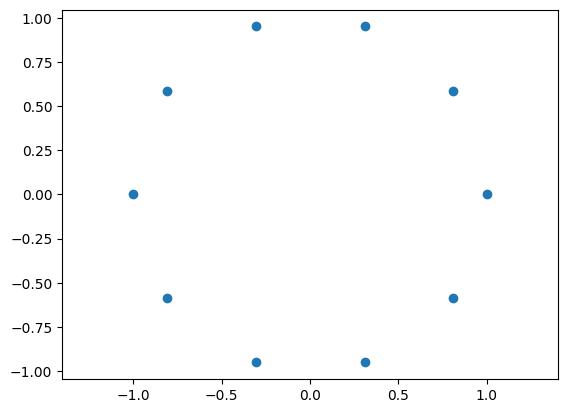

In [137]:
circle_points = get_n_points_on_circle(10)
plt.figure(dpi=100)
plt.scatter(circle_points[:,0], circle_points[:,1])
plt.axis('equal')

### Question 3 - Solving the Embedding

**Solve for the uv coordinate using ```scipy.sparse.linalg.spsolve```**

Tip: To select ```W[id_int,id_int]``` on a sparse matrix ```W[id_int,id_int]```, use ```W[id_int,:][:,id_int]```.

Because your border points are *ordered*, you will need to use an *ordered* list if border edges. We provide a function below which generates an *ordered* list of border edges using your ```get_border_edges``` function from Question 1.

In [138]:
def find_next_edge(current_edge, remaining_edges):
        for i, edge in enumerate(remaining_edges):
            if current_edge[1] in edge:
                if edge[0]==current_edge[1]:
                  return i, edge #if edge[0]==current_edge[1] else edge[::-1]
                else:
                  return i,edge[::-1]

        return None, None

def build_ordered_edges(triangles):
    """
    Compute an ordered list of edges that form a path around the border of the mesh.

    Parameters
    ----------
    triangles : ndarray of shape (n_triangles, 3)

    Returns
    -------
    ordered_edge_list : list of list of length n_border_edges.
                        The border edges of the mesh. Element i contains the two
                        vertices of the i-th border edge.
    """
    ordered_edge_list=[]
    border_edges=get_border_edges(triangles)
    current_edge=border_edges[0]
    remaining_edges=border_edges[1:]

    #on part maintenant d'une extremité pour arriver à l'autre extrémité et donc oublier aucune arrête
    while True:

        ordered_edge_list.append(current_edge)
        i, current_edge = find_next_edge(current_edge, remaining_edges)
        if i==None:
            break
        del(remaining_edges[i])
    print(len(ordered_edge_list)==len(border_edges))

    return ordered_edge_list

In [139]:
# Load the mesh and compute the Laplacian
mesh1 = TriMesh('./data/sphere_cut_uv.obj').process(k=0)
uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')[-1]
# Get the list of ordered edges and the Laplacian
ordered_edges = build_ordered_edges(mesh1.faces)
W = mesh1.W

renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

True


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_fec717fd-30c8-4b27-89ff-ad1f7dfa0592'.

In [140]:
 #TODO Compute the embedding u,v using the text above.

ordered_edges = build_ordered_edges(mesh1.faces)
# On identifie les indices en bordure et à l'intérieur
id_bnd = [edge[0] for edge in ordered_edges]
id_int = [i for i in range(mesh1.n_vertices) if i not in id_bnd]

# On genere les points de la bordure
uv_border = get_n_points_on_circle(len(id_bnd))

# On resoud sur u et v l'equation linéaire
W = mesh1.W
u_int = scipy.sparse.linalg.spsolve(W[id_int, :][:, id_int], -W[id_int, :][:, id_bnd] @ uv_border[:, 0])
v_int = scipy.sparse.linalg.spsolve(W[id_int, :][:, id_int], -W[id_int, :][:, id_bnd] @ uv_border[:, 1])

# Il ne reste qu'à compléter uv_total avec l'intérieur et la bordure

uv_total = np.zeros((mesh1.n_vertices, 2)) ### (n,2) computed UV coordinates (takes more than 1 line)
uv_total[id_bnd] = uv_border #on initialise sur la bordure
uv_total[id_int, 0] = u_int #puis sur l'intérieur en x puis y
uv_total[id_int, 1] = v_int

flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total


True


In [141]:
# Visualize the results
# Flattened coordinates with regular grid
renderer.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=False, multiple_sides=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_ab0f6c22-b99a-401e-9210-72abc3ad6bbd'.

In [142]:
# We can take the regular grid back to the sphere
#renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, wireframe=True)

# Or take the Texture of the sphere to the flat world
renderer.plot_texture(flat_coords, mesh1.faces, uv_total, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_5cfca43a-be5b-4886-be49-fdfad1316b64'.

Let's now visualize how it would render on the Earth

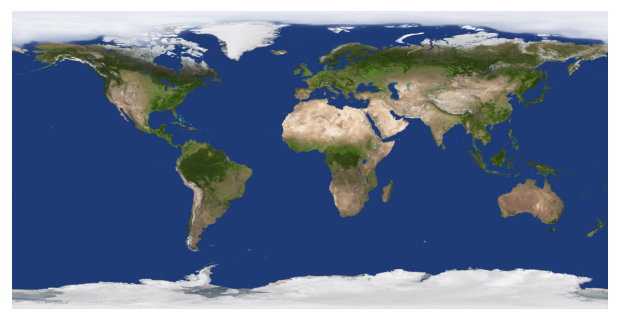

In [143]:
image = plt.imread('data/earth_daymap.jpg')
plt.figure(dpi=120)
plt.imshow(image)
plt.axis('off');

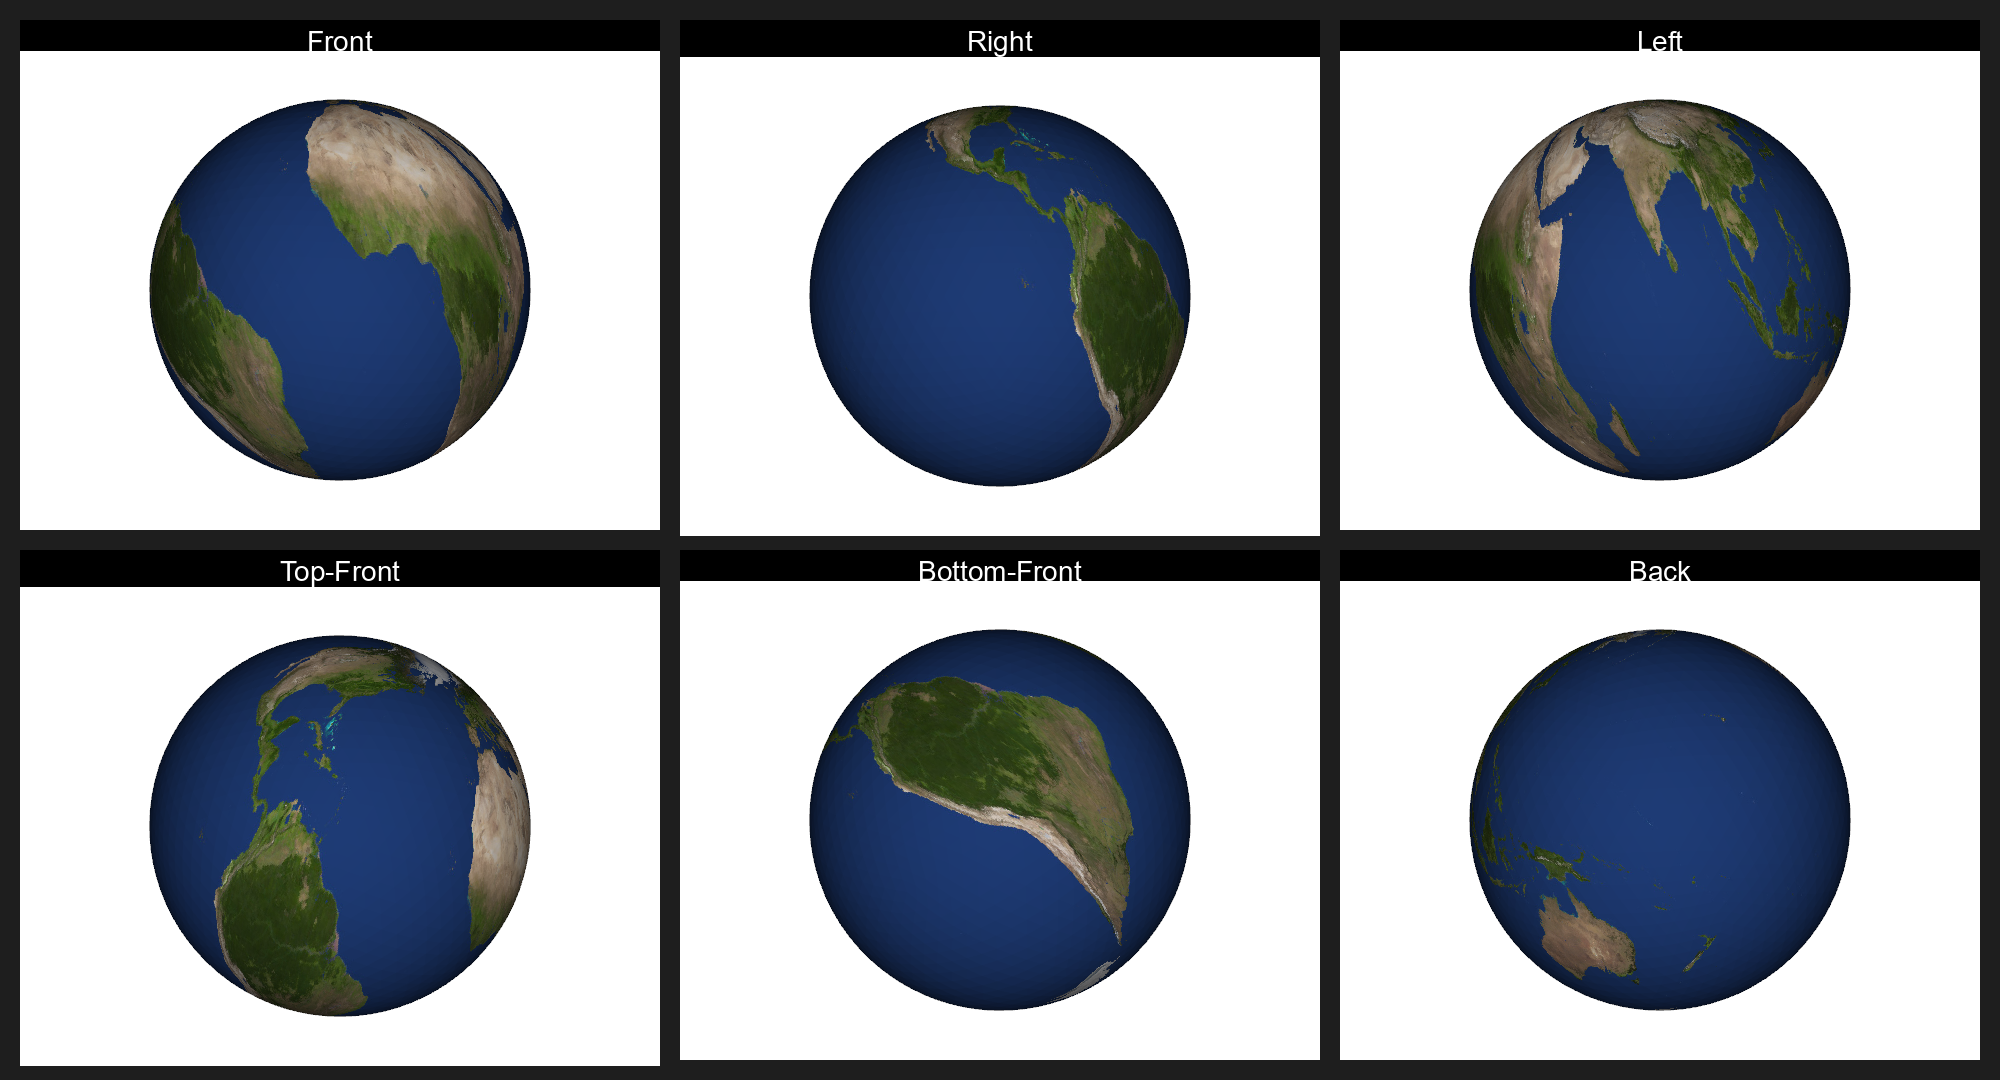

In [144]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_map, texture_img="data/earth_daymap.jpg", wireframe=False)

Le résultat est très satisfaisant !

### If you want to visualize it better, save it and load in Meshlab.

In [145]:
os.makedirs('results', exist_ok=True)
shutil.copyfile('data/earth_daymap.jpg', 'results/earth_daymap.jpg')


# THIS EXPORTS A .OBJ FILE WITH TEXTURE AND MATERIAL INFORMATION. DOWNLOAD AND OPEN WITH MESHLAB
TriMesh(flat_coords, mesh1.faces).export_texture('results/tutte_earth.obj', uv_map, texture_im='earth_daymap.jpg')

## 1.2 Least Square Conformal Map

Conformal maps are special type of parametrization which preserves angles and circles. On a smooth surface, they are characterized by the relationship between the gradient of the coordinate $u$ and the coordinate $v$
$$ \nabla u = n \times \nabla v $$
where $n$ is the surface normal. On a triangle mesh, the coordinates $(u,v)$ are computed using a linear least-squares problem
$$ \min_{u,v} \sum_{t \in T} A_t |\nabla u - n \times \nabla v|^2 \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
where $A_t$ is the area of triangle $t$. As explained in the course, the objective function can be written in term of the Laplacian matrix $W$. This leads to the smallest eigenvalue problem
$$ \min_{u,v} \begin{pmatrix} u \\ v \end{pmatrix}^\top \begin{pmatrix} W & -M \\ -M^\top & W \end{pmatrix} \begin{pmatrix} u & v \end{pmatrix} \text{ subject to the constraint: } \sum_i u_i^2 + v_i^2 = 1 $$
The sparse matrix $M$ of size $n_v \times n_v$ is given by
$$ M_{ij} = \begin{array}{ll}
0 & \text{if $i$ or $j$ is an interior vertex } \\
1/2 & \text{if $i$ to $j$ is a positive edge of the boundary triangle} \\
-1/2 & \text{if $i$ to $j$ is a negative edge of the boundary triangle}
\end{array} $$

Positive edges are edges that appear when going around a face in the order provided in the file. Negative edges are when going the opposite direction.

*Tips:* To assemble this matrix simply accumulate $\pm\frac{1}{2}$ values for all triangles using the triangle list using the formula above. Since interior edges appear twice in opposite direction in the mesh, their coefficient will vanish for them, and only values for border edges will remin


1. Build the sparse matrix `M`
2. Compute the LSCM parametrization using `scipy.sparse.linalg.eigs`
3. Extract the boundary coordinate of the parametrization and use them to compute a Tutte embedding

### Question 4 - Build M

In [146]:
def build_M(faces):
    """
    Build the M matrix above with values only at border edges.
    M can be build by adding the formula for M_ij for each edge of each face on the mesh.
    Coefficients at interior edges will vanish because they appear twice with opposite signs.

    Parameters
    ----------
    faces : ndarray of shape (n_faces, 3)

    Returns
    -------
    M : scipy.sparse.csr_matrix of shape (n_vertices, n_vertices)
    """
    n_vertices = faces.max() + 1
    row = []
    col = []
    data = []

    # on parcourt toutes les arretes de toutes les faces
    for tri in faces:
        # edges: (i,j), (j,k), (k,i)
        i, j, k = tri
        # (i, j)
        row.append(i)
        col.append(j)
        data.append(0.5)
        row.append(j)
        col.append(i)
        data.append(-0.5)
        # (j, k)
        row.append(j)
        col.append(k)
        data.append(0.5)
        row.append(k)
        col.append(j)
        data.append(-0.5)
        # (k, i)
        row.append(k)
        col.append(i)
        data.append(0.5)
        row.append(i)
        col.append(k)
        data.append(-0.5)

    M = scipy.sparse.csr_matrix((data, (row, col)), shape=(n_vertices, n_vertices))
    return M

### Question 5 - Solve the system

Use scipy [bmat function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bmat.html) to build sparse matrices from blocks.
Use scipy

Try with the two meshes (diablo doesn't have uv map)

In [147]:
#mesh1 = TriMesh("./data/diablo_cut2.obj").process(k=0)
mesh1 = TriMesh("./data/sphere_cut_uv.obj").process(k=0)
uv_map = v,f,uv_map = mesh_utils.read_obj_texture('./data/sphere_cut_uv.obj')
W = mesh1.W

In [148]:
M = build_M(mesh1.faces)

system_matrix = scipy.sparse.bmat([[W, -M], [-M.transpose(), W]], format='csr') #TODO#TODO

res_eigenvalues, res_eigenvectors = scipy.sparse.linalg.eigsh(system_matrix, k=3, which='LM', sigma=-0.001)

# Only take the real part

res_eigenvectors = res_eigenvectors.real

# Check that first 2 eigenvalues are 0
print(res_eigenvalues)

#valeurs proche de 0

[-1.26634814e-16 -1.17744356e-16  1.32033361e-05]


In [149]:
uv_coords = res_eigenvectors[:,2].reshape((mesh1.n_vertices,2), order='F')

renderer.plot_texture(mesh1.vertices, mesh1.faces, uv_coords)
#plu.plot_texture(flat_coords, mesh1.faces, flat_coords)


# For the Sphere
#plu.plot_texture(flat_coords, mesh1.faces, uv_map, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_3b224b4e-6713-4514-9f61-afd2cd5d9bbc'.

In [150]:
renderer.plot_texture(flat_coords, mesh1.faces, uv_coords, wireframe=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_bd8cfc1b-ac12-47e8-a376-f1278d5634f1'.

you can again visualize with the earth map on the sphere

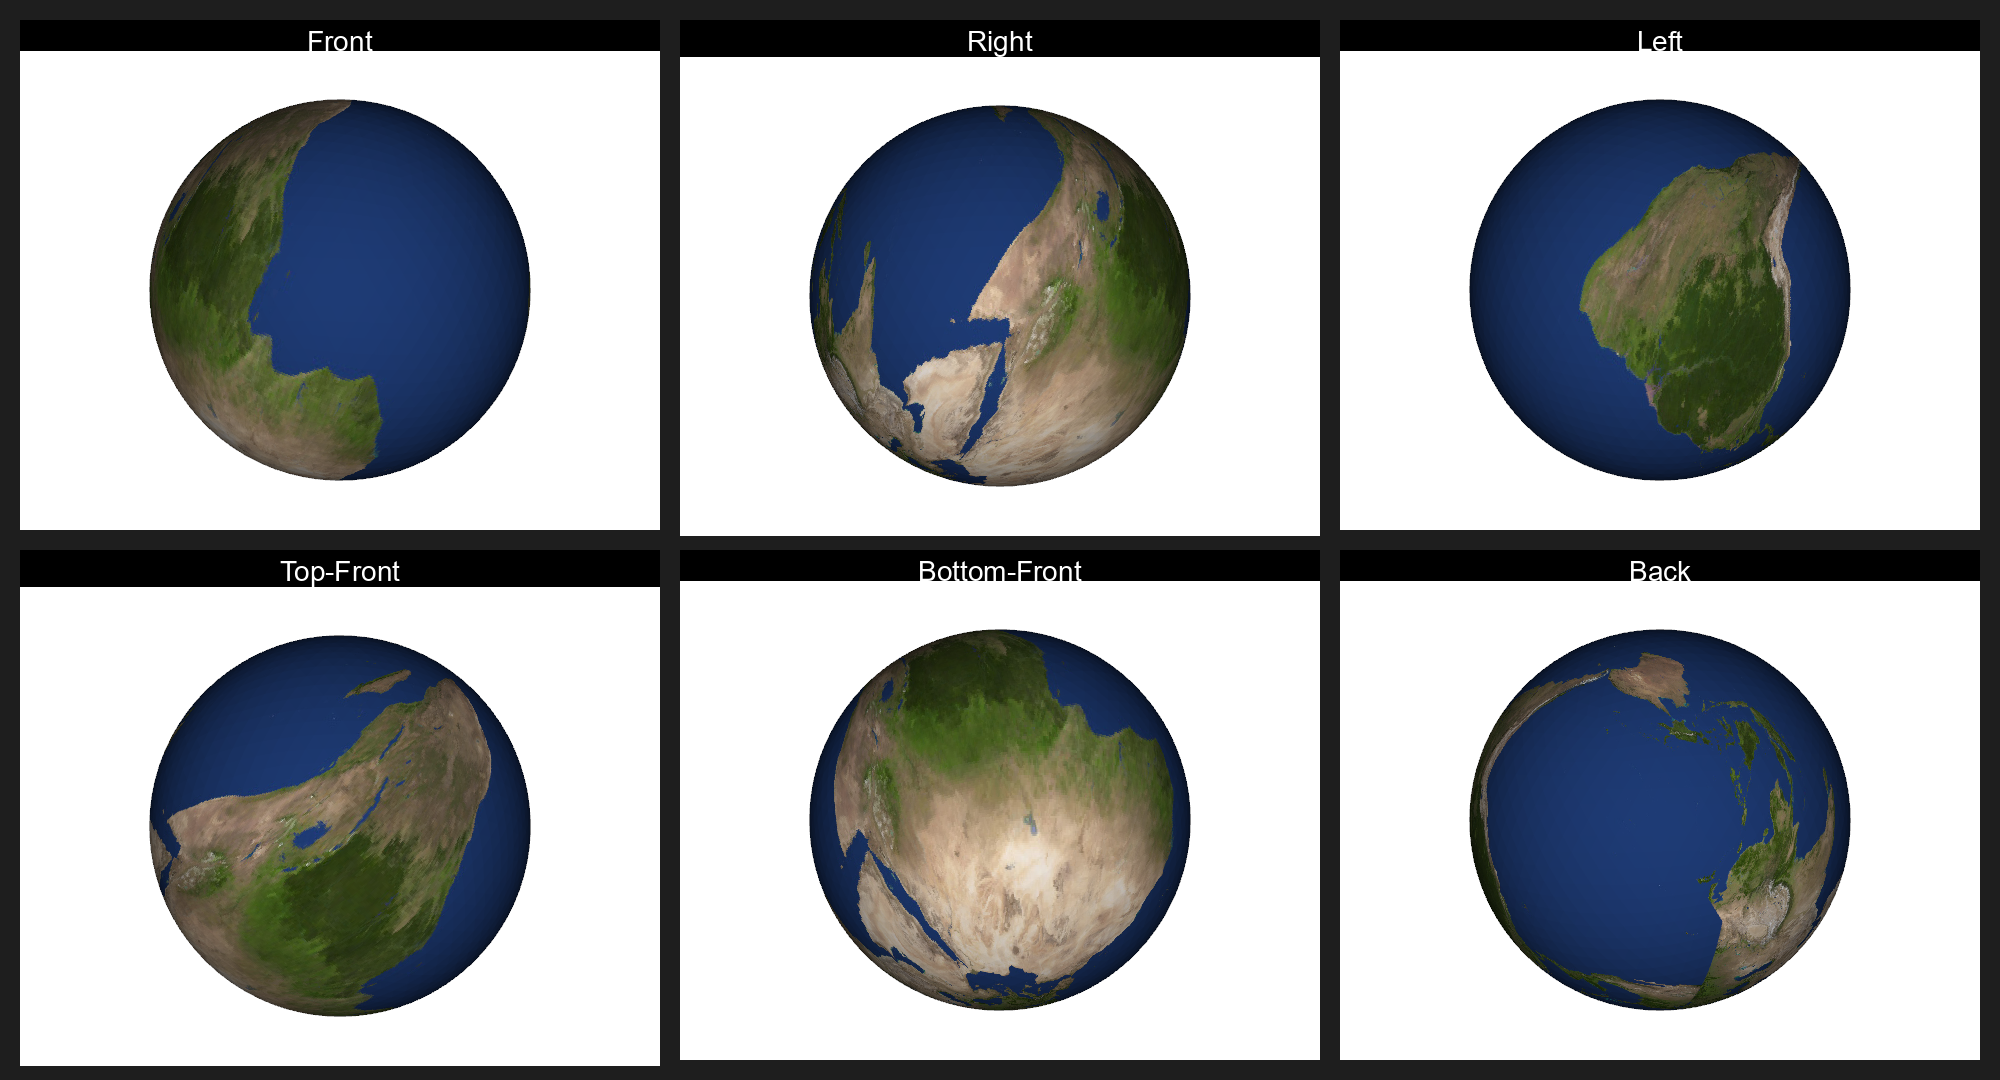

In [151]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_coords, texture_img="data/earth_daymap.jpg", wireframe=False)

Le résultat est correct mais on observe tout de même des irrégularité sur la conversion de taille ainsi que sur la bordure

In [152]:
flat_coords =  np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_total
TriMesh(flat_coords, mesh1.faces).export_texture('results/lscm_earth.obj', uv_coords, texture_im='earth_daymap.jpg')

###  Question 6 - Extract the Border and compute the tutte embedding on the same border (with ordering)

In [153]:
id_bnd = [edg[0] for edg in ordered_edges]
id_int = [i for i in range(mesh1.n_vertices) if i not in id_bnd]

# On extrait les points de la bordure
uv_border = uv_coords[id_bnd]


# On resoud sur u et v l'equation linéaire
W = mesh1.W
u_int = scipy.sparse.linalg.spsolve(W[id_int, :][:, id_int], -W[id_int, :][:, id_bnd] @ uv_border[:, 0])
v_int = scipy.sparse.linalg.spsolve(W[id_int, :][:, id_int], -W[id_int, :][:, id_bnd] @ uv_border[:, 1])

# Il ne reste qu'à compléter uv_total avec l'intérieur et la bordure

uv_tutte_2 = np.zeros((mesh1.n_vertices, 2)) ### (n,2) computed UV coordinates (takes more than 1 line)
uv_tutte_2[id_bnd] = uv_border #on initialise sur la bordure
uv_tutte_2[id_int, 0] = u_int #puis sur l'intérieur en x puis y
uv_tutte_2[id_int, 1] = v_int

flat_coords = np.zeros((mesh1.n_vertices,3))
flat_coords[:,:2] = uv_tutte_2
print(np.linalg.norm(uv_tutte_2 - uv_coords))

0.0007723369868303412


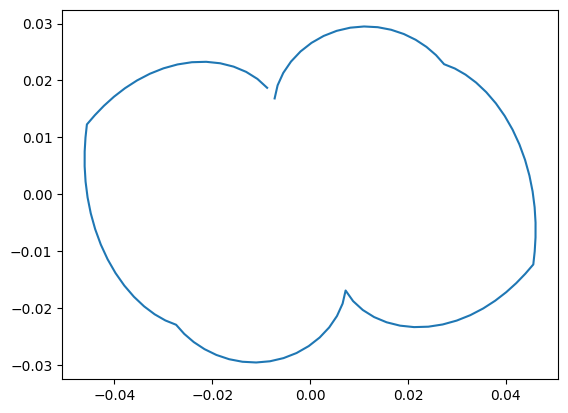

In [154]:
plt.plot(uv_border[:, 0], uv_border[:, 1]) # Just a check: we plot to verify that the border is continuous

La bordure est bien continue

In [155]:
renderer.plot_texture(flat_coords, mesh1.faces, uv_tutte_2, wireframe=True, multiple_sides=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-2.106651…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_3e9f779e-0568-4982-b5b1-8ef602d6fe4e'.

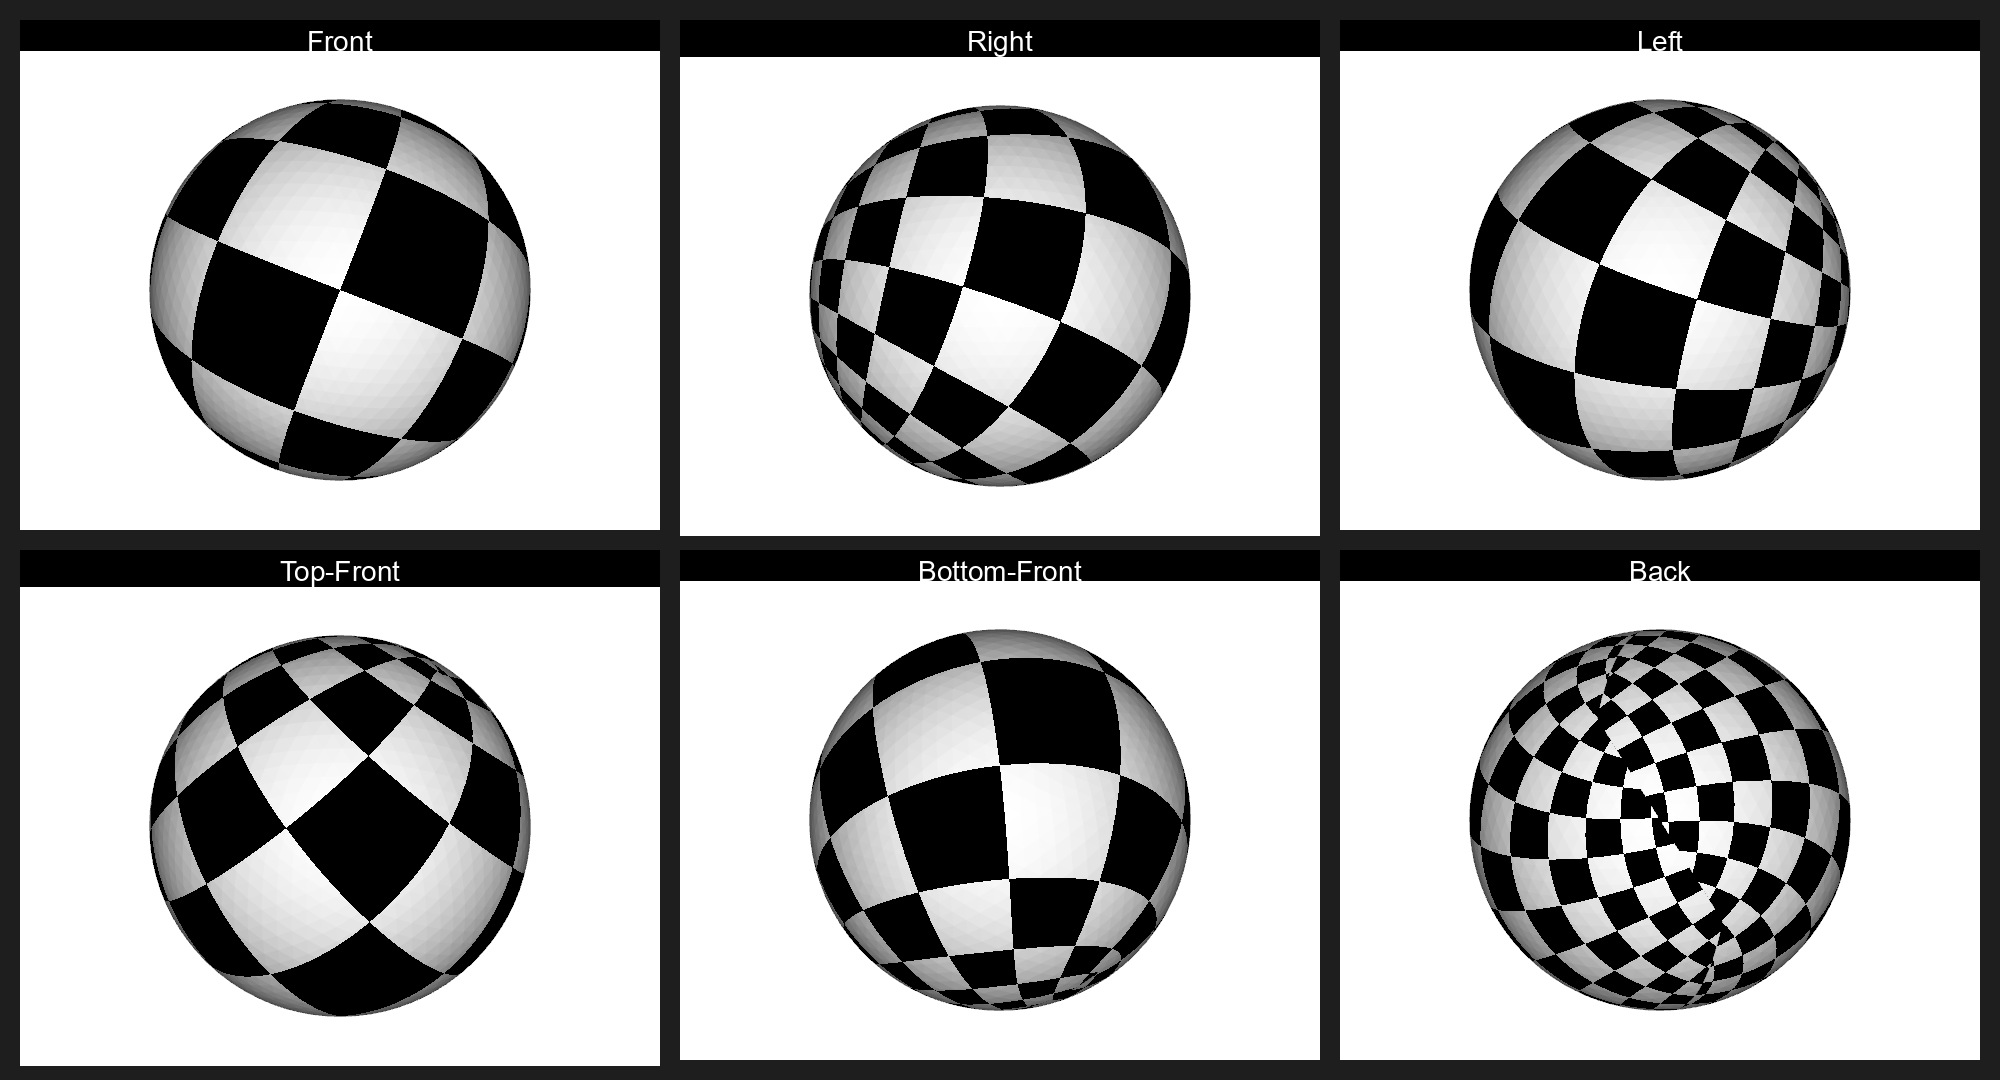

In [156]:
vtkrenderer.plot_texture(mesh1.vertices, mesh1.faces, uv_tutte_2, wireframe=True)

# 2 Surface Alignment

## 2.1 Iterative Closest Point

The goal of this algorithm is to align two point clouds $X = \{ x_i \}$ and $Y = \{ y_i \}$ using only rigid transformations -- translation and rotation. It is standard algorithm to align 3D scans taken from different viewpoints. The most basic implementation iterates between three steps until convergence:

1. For each point of $X$ compute the closest point in the set $Y$. This assignment is given by the table $p$
$$ p_i = \arg\min_{j} \|x_i - y_j\|^2 .$$
This can be done efficiently with a knn-search.

2. Find the translation that best align the point cloud given the assignment $p$
$$ \min_{t \in \mathbb{R}^3} \sum_i \|x_i + t - y_{p_i}\|^2 .$$
This problem can be solved exactly with the formula $t = \frac{1}{|X|}\sum_i y_i - x_i$.

3. Compute the rotation aligning the point cloud after translation:
$$ \min_{R} \sum_i \|Rx_i + t - y_{p_i}\|^2 .$$
This is an [orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem) and can be solved efficiently using a Singular Value Decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). Let the matrix $A = \sum_i (t-y_{p_i})x_i^\top$ be decomposed as $A = U S V^\top$ where $U,V$ are unitary matrices and $S$ a diagonal matrix. The optimal rotation is given by $R = U D V^\top$ with $D$ a diagonal matrix with $+1$ on the diagonal corresponding to the two largest singular values and $\pm 1$ on the smallest singular value. The sign is chosen so that $\det R = 1$.

4. Update the position of $X$: $x_i \leftarrow Rx_i+t$


**To do:**
1. Implement the steps
2. Align the Armadilo

### Question 7 - Compute Nearest Neighbor

To speed up computation, use `scipy.spatial.cKDTree`.

In [157]:
def compute_nearest_neighbor(X, Y):
    """
    Compute the nearest neighbor in Y for each point in X

    Parameters:
    -----------
    X : (n, d) array of points
    Y : (m, d) array of points

    Returns:
    --------
    nearst_neighbor : (n,) array of indices of the nearest neighbor in Y for X
    """
    # TODO DO NOT USE LOOPS

    tree = scipy.spatial.cKDTree(Y)

    _, nearest_neighbor = tree.query(X, k=1)

    return nearest_neighbor
    # querier = KNNSearch(X)
    # nn_indices = querier.query(Y, 1)
    # return nn_indices

### Question 8 - Compute optimal rotations and translation

On veut trouver $(R, t)$ qui minimise
$ E(R, t) = \sum_{i=1}^n \| R x_i + t - y_i \|^2 $

sous la contrainte $ R^\top R = I $

1. Élimination de la translation :

Les barycentres sont :
$
\mu_X = \frac{1}{n}\sum_{i=1}^n x_i, \quad
\mu_Y = \frac{1}{n}\sum_{i=1}^n y_i. $

En posant les points centrés :
$
\tilde{x}_i = x_i - \mu_X,
\tilde{y}_i = y_i - \mu_Y,
$
la translation optimale pour un R donné est :
$
t = \mu_Y - R \mu_X.
$

2. Réduction du problème à la rotation :

On obtient donc :
$
E(R) = \sum_{i=1}^n \| R \tilde{x}_i - \tilde{y}_i \|^2.
$

Si on développe :
$
E(R) = \sum_i (\| \tilde{x}_i \|^2 + \| \tilde{y}_i \|^2) - 2 \operatorname{trace}(R H)
$
où :
$
H = \sum_i \tilde{x}_i \tilde{y}_i^\top.
$

Minimiser E(R) revient donc à maximiser :
$ \operatorname{trace}(R H) $ pour $R \in O(d)$


3. Décomposition SVD :

On applique donc la SVD à H :
$
H = U \Sigma V^\top
$
avec U, V  orthogonales et $ \Sigma = \operatorname{diag}(\sigma_1, \dots, \sigma_d) $

Alors :
$
\operatorname{trace}(R H) = \operatorname{trace}(V^\top R U \Sigma).
$
Posons $ Q = V^\top R U $ (orthogonale comme produit de matrice orthogonale), donc :
$
\operatorname{trace}(R H) = \sum_i \sigma_i Q_{ii}.
$

Par l’inégalité de von Neumann :
$
\operatorname{trace}(R H) \le \sum_i \sigma_i,
$
avec égalité si Q = I

Donc :
$
\underline{R = V U^\top}.
$

4. Correction de la réflexion :
Si $\det(R) < 0 $, on force une rotation propre en posant :
$
D = \operatorname{diag}(1, \dots, 1, \det(V U^\top))
R = V D U^\top.
$


In [158]:
def compute_rigid_transform(X_source, X_target):
    """
    Compute the optimal rotation matrix and translation that aligns two point clouds of the same size X_source and X_target.
    This rotation should be applied to X_source.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (n, d) array of points

    Returns:
    --------
    R : (d, d) rotation matrix
    t : (d,) translation vector
    """
    # TODO

    #On utilise la méthode SVD

    # On centre les deux nuages de points pour ignorer la translation
    mu_X = np.mean(X_source, axis=0)
    mu_Y = np.mean(X_target, axis=0)

    X_centered = X_source - mu_X
    Y_centered = X_target - mu_Y

    # Matrice de covariance
    H = X_centered.T @ Y_centered

    # Décomposition en valeurs singulières
    U, S, Vt = np.linalg.svd(H)

    # Calcul de la rotation optimale
    R = Vt.T @ U.T

    # Correction si réflexion
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Calcul de la translation pour terminer
    t = mu_Y - R @ mu_X


    return R, t

### Question 9 - Apply the ICP algorithm
We provide a function to apply a rigid transformation ```R,t``` to a point cloud

In [159]:
def transform_pointcloud(X,R,t):
    """
    Transform a point cloud X by a rotation matrix R and a translation vector t.

    Parameters:
    -----------
    X : (n, d) array of points
    R : (d, d) rotation matrix
    t : (d,) translation vector

    Returns:
    --------
    X_transformed : (n, d) array of transformed points
    """
    return X @ R.T + t

In [160]:
def icp_align(X_source, Y_target, n_iter=10):
    """
    Align two point clouds X_source and Y_target using the ICP algorithm.

    Parameters:
    -----------
    X_source : (n, d) array of points
    Y_target : (m, d) array of points
    n_iter   : int - number of iterations of the ICP algorithm

    Returns:
    --------
    X_aligned : (n, d) array of aligned points
    """
    X_aligned = X_source.copy()
    for i in range(n_iter):
        nn_indices = compute_nearest_neighbor(X_aligned, Y_target)
        Y_nn = Y_target[nn_indices]
        R, t = compute_rigid_transform(X_aligned, Y_nn)
        X_aligned = transform_pointcloud(X_aligned, R, t)
    return X_aligned

In [161]:
def plot_superimposed(mesh1, mesh2, color_1=[139, 0, 139], color_2=[210, 105, 30], *args, **kwargs):
    """
    Plot the superposition of the two meshes
    """
    #2B7FFF#2B7FFF
    if meshplot:
        cmap_1 = np.ones(mesh1.vertices.shape)*np.array(color_1)/255.
        cmap_2 = np.ones(mesh2.vertices.shape)*np.array(color_2)/255.
    else:
        cmap_1 = np.ones(mesh1.vertices.shape)*np.array(color_1)
        cmap_2 = np.ones(mesh2.vertices.shape)*np.array(color_2)
    cmap = np.concatenate([cmap_1, cmap_2], axis=0)
    mesh = TriMesh(np.concatenate([mesh1.vertices, mesh2.vertices], axis=0),
                   np.concatenate([mesh1.faces, mesh2.faces+mesh1.n_vertices], axis=0)).process(k=0)
    return renderer.plot(mesh, cmap, *args, **kwargs)

mesh1 = TriMesh("./data/Armadillo_1.off")
mesh2 = TriMesh("./data/Armadillo_2.off")

plot_superimposed(mesh1, mesh2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5006730…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_f61d69fb-cf98-461b-891e-6859a584f0a7'.

In [162]:
# VISUALIZE ICP Result
vert1_aligned = icp_align(mesh1.vertices, mesh2.vertices, n_iter=10)

plot_superimposed(TriMesh(vert1_aligned, mesh1.faces), mesh2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5234178…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_81d7267b-fa8c-406d-80d9-dca81674736c'.

En effet l'alignement est bon, mais l'ICP ne suffit pas ici car il faut de la déformation .

## As-rigid-as possible deformation

This model of  <a href=\"https://igl.ethz.ch/projects/ARAP/arap_web.pdf\">deformation</a> tries to preserves at best the shape features. As explained in the course, given a triangle mesh ($T$: triangle list, $X$: vertex positions) the goal is to find new vertex positions $Y = \\{ y_i\\}$ which are as-close-as possible to a local rotation of the initial position $X$. More precisely, we store a rotation matrix $R_i$ at each vertex $i$ and find the rotations $R$ and position $y$ minimizing\n",

$$ \min_{y,R} \sum_{i} \sum_{j \in N_i} w_{ij} \| y_i - y_j - R_i (x_i - x_j) \|^2, \text{  $y$ subject to position constraint,}$$

with $w_{ij}$ the cotan-weight and $N_i$ the set of vertices adajcent to $i$.
To solve this problem, we iterate between solving for best the position and for rotations.
1. Finding the optimal position $y$ is a constrained Laplacian problem (just like the first question)
$$ W y = b, \quad \text{where } b_i = \sum_{j \in N_i} \frac{w_{ij}}{2} (R_i+R_j) (x_i - x_j) \text{ for each vertex $i$}, $$
and $y$ is constrained at some given vertices.
2. Finding the optimal rotation $R_i$ amounts for solving an orthogonal Procrustes problem for each vertex $i$ where the matrix $B_i = \sum_{j \in N_i} w_{ij} (y_i - y_j) (x_i - x_j)^\top$ is decomposed via a SVD (see step 3 of previous question).

**To do:**
1. Provide functions to compute the initial rotations. This is divided into two subproblems: estimating the covariance, and then computing the rotations using SVD.
2. Fill the function to compute the right side of the optimization
3. Write the optimization loop with the system inside. It consists of alternating between computing b with estimated positions, and solving for new positions.

We provide a function to compute a list of neighbors for each vertex

In [163]:
def get_per_vertex_neighbors(faces):
    """
    Compute per-vertex neighbors from a list of triangles

    Parameters:
    -----------
    faces : (n, 3) array of vertex indices for each triangle

    Returns:
    --------
    neighbors : list of lists of vertex indices
    """

    neighbors = [set() for _ in range(faces.max()+1)]
    for face in faces:
        neighbors[face[0]].add(face[1])
        neighbors[face[0]].add(face[2])

        neighbors[face[1]].add(face[0])
        neighbors[face[1]].add(face[2])

        neighbors[face[2]].add(face[0])
        neighbors[face[2]].add(face[1])

    return [list(n) for n in neighbors]

### Question 10 - Compute the covariance (Matrix B_i)

On utilise tout simplement la formule du cours:

$B_i = \sum_{j \in \mathcal{N}(i)} w_{ij} \, (u_i - u_j)(x_i - x_j)^\top$

In [164]:
def get_arap_edge_covariance(x,y, cotan_matrix, per_vertex_neighbors):
    """
    Compute the covariance matrix of the edge between x and y. (Formula B_i)

    Parameters:
    -----------
    x : (n,3) array of coordinates of x
    y : (n, 3) array of coordinates of y
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    covariances : (n, 3, 3) covariance matrices of the edge between x and y
    """
    covariances = np.zeros((len(x), 3, 3))

    for i in range(len(x)): #on parcourt toutes les sommets, puis leurs voisins
        for j in per_vertex_neighbors[i]:
            w_ij = cotan_matrix[i, j]
            diff = (x[i] - x[j]).reshape(3, 1) # pour en faire un vecteur colonne
            diff2= (y[i] - y[j]).reshape(3, 1).T # vecteur ligne
            covariances[i] += w_ij * (diff @ diff2)

    return covariances

### Question 11 - Compute Rotations from Covariance (compute R_i)

In [165]:
def get_rot_from_covariances(covariances):
    """
    Compute optimal rotation matrix from edge covariance matrices, using SVD.

    Parameters:
    -----------
    covariances : (n, 3, 3) covariance matrices for each vertex

    Returns:
    --------
    rots : (n, 3, 3) rotation matrices for each vertex
    """
    rots = np.zeros_like(covariances)

    for i in range(len(covariances)):
        U, S, Vt = np.linalg.svd(covariances[i])
        #même chose que pour la rigid transform
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        rots[i] = R
    return rots

### Question 12 - Compute Rotated vertices (vector b_i)

Pareil avec la formule :

$b_i = \sum_{j \in \mathcal{N}(i)} \frac{w_{ij}}{2} \, (R_i + R_j)(x_i - x_j)$

In [166]:
def compute_ARAP_rotated_vert(vertices, rotations, cotan_matrix, per_vertex_neighbors):
    """
    Compute the right hand term of the ARAP linear system (formula b_i)

    Parameters:
    -----------
    vertices : (n, 3) array of vertices
    rotations : (n, 3, 3) array of rotation matrices
    cotan_matrix : (n,n) cotan matrix of the mesh
    per_vertex_neighbors : (n,) list with list of neighbors of each vertex

    Returns:
    --------
    b : (n, 3) right hand term of the ARAP linear system
    """
    b = np.zeros((len(vertices), 3))
    for i in range(len(vertices)):
        for j in per_vertex_neighbors[i]:
            w_ij = cotan_matrix[i, j]
            b[i] += w_ij / 2 * (rotations[i] + rotations[j]) @ (vertices[i] - vertices[j])

    return b


### Question 13 - Apply ARAP Deformation.

We first load the mesh and visualize it with the objective landmark deformation.

In [167]:
mesh3 = TriMesh("data/cactus.off").process(k=0)

# THE ID OF THE LANDMARKS
id_mouv = [1756, 1298, 1663, 118, 637, 1842]
id_lock = id_mouv
# THE EXPECTED POSITIONS OF THE LANDMARKS AFTER OPTIMIZATION
disp = np.array([[0,-0.25,-0.46], [0,-0.4,-0.3], [0,-0.55, -0.], [0, -0.08, -0.05], [0, -0.08, -0.05], [0, 0, 0]])
positions_target = mesh3.vertices[id_lock] + disp

In [168]:
np.tile(np.arange(len(id_lock)),2)

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

In [169]:
# VISUALIZE THE LANDMARKS
renderer.plot(mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2),
         colormap='jet')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5001154…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_83f83e7a-bc9e-4fbe-adaa-b41250a1004d'.

### ARAP Loop

Write the ARAP loop by filling in the blanks

In [176]:
vertex_neighbors = get_per_vertex_neighbors(mesh3.faces)
n_arap_loop = 20
W = mesh3.W.copy()
print(W.shape, mesh3.n_vertices)
# Interior vertices
id_in = [i for i in range(mesh3.n_vertices) if i not in id_lock]

# Initial guess for the vertices
init_res= mesh3.vertices.copy()
init_res[id_lock]= positions_target

for i in range(n_arap_loop):

    # Compute rotation matrices
    covariances = get_arap_edge_covariance(mesh3.vertices, init_res, W, vertex_neighbors)
    rotations = get_rot_from_covariances(covariances)
    b_term = compute_ARAP_rotated_vert(mesh3.vertices, rotations, W, vertex_neighbors)

    # Compute right hand term and left hand term of ARAP SYSTEM
    # Think about the constraint, go back the the text in part 1.1 to see how to build the constrained system

    lhs = W[id_in,:][:,id_in]
    rhs = b_term[id_in] - W[id_in,:][:,id_lock] @ positions_target

    res = scipy.sparse.linalg.spsolve(lhs, rhs)

    ## Add the update of your guess

    init_res[id_in]=res

final_res=init_res

(1856, 1856) 1856


In [171]:
last_mesh = TriMesh(final_res, mesh3.faces)

In [172]:
plot_superimposed(last_mesh, mesh3,
         points=np.concatenate([mesh3.vertices[id_lock], positions_target]),
         cmap_p=np.tile(np.arange(len(id_lock)),2), point_size=0.01,
         colormap='jet')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5001154…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_eede92e8-e278-4de2-bbeb-0121338bc24f'.

On observe que la déformation est correct (la forme global est conservé) et les positions cibles sont respectées, cependant certaines formes locals ne sont pas conservé comme bouts du cactus qui sont arrondi vers l'intérieur (et c'est plus ou moins logique car c'est aussi un minimum local).

### Question 15: Write a non-rigid registration algorithm

Now that you have a non-rigid deformation model, make a non-rigid icp function such that it does:

1. Compute approximate spatial nearest neighbor
2. Use this as a guess for ARAP and compute ARAP deformation
3. Updates the approximate spatial guess

Finally, plot the registration. All main functions are ready, it's time to write a bit on your own.

In [ ]:
def non_rigid_icp_align(mesh_source, Y_target, n_iter=10, arap_iter=10):
    """
    Align the vertices of a source mesh to a target point cloud using a non-rigid ICP algorithm with ARAP.

    Parameters:
    -----------
    mesh_source : TriMesh - The source mesh object
    Y_target : (m, d) array of points - The target point cloud
    n_iter   : int - number of iterations for the outer loop
    arap_iter: int - number of iterations for the ARAP loop

    Returns:
    --------
    X_aligned : (n, d) array of aligned points - The deformed vertices of the source mesh
    """
    X_aligned = mesh_source.vertices.copy()
    vertex_neighbors = get_per_vertex_neighbors(mesh_source.faces)
    W = mesh_source.W.copy()
    X_source_original = mesh_source.vertices.copy()

    #On utilise une ICP simple pour une meilleur initialisation
    X_aligned = icp_align(X_aligned, Y_target, n_iter=10)

    for i in range(n_iter):
        #v1) On utilise la fonction déjà utilisé pour le calcul de neirest neighbour

        nn_indices = compute_nearest_neighbor(X_aligned, Y_target)
        Y_nn = Y_target[nn_indices] # ce sont les points targets (cibles)

        # Step 2: On utilise ça pour comme guess pour la ARAP

        # Dans ce set-up, toutes les vertices sont "constraints" à bouger vers leur voisin le plus proche.

        positions_target = Y_nn

        # Initialisation :
        current_arap_res = X_aligned.copy()

        for j in range(arap_iter):

            covariances = get_arap_edge_covariance(X_source_original, current_arap_res, W, vertex_neighbors)
            rotations = get_rot_from_covariances(covariances)

            # Note: The b_term is computed based on the original vertices (X_source_original) and the calculated rotations.
            b_term = compute_ARAP_rotated_vert(X_source_original, rotations, W, vertex_neighbors)

            # On résoud le système :  W * y = b_term avec constraintes y_k = positions_target_arap[k]

            num_vertices = X_aligned.shape[0]
            constrained_matrix = W.copy().tolil() # on enlève le format csr pour pouvoir modifier les lignes directement
            constrained_rhs = b_term.copy()

            # Pour chaque vertex, on associe la ligne correspondante dans la matrice
            # pour enforcer la position de target/cible de son voisin le plus proche.
            for k in range(num_vertices):
                constrained_matrix[k, :] = 0
                constrained_matrix[k, k] = 1
                constrained_rhs[k] = positions_target[k]

            constrained_matrix = constrained_matrix.tocsr() #on repasse en csr pour la résolution

            # On obtient la nouvelle position total
            new_arap_res = scipy.sparse.linalg.spsolve(constrained_matrix, constrained_rhs)
            current_arap_res = new_arap_res

        X_aligned = current_arap_res

    return X_aligned


In [174]:
mesh1 = TriMesh("./data/Armadillo_1.off").process(k=0)
mesh2 = TriMesh("./data/Armadillo_2.off").process(k=0)

# Visualisation du résultat de la transformation non rigide:
vert1_aligned_non_rigid = non_rigid_icp_align(mesh1, mesh2.vertices, n_iter=5, arap_iter=5)
plot_superimposed(TriMesh(vert1_aligned_non_rigid, mesh1.faces), mesh2)

/content/mesh_utils/laplacian.py:113: RuntimeWarning: invalid value encountered in divide
  A1 = np.einsum('ij,ij->i', -u2, u3) / (L2*L3)  # (m,)
/content/mesh_utils/laplacian.py:114: RuntimeWarning: invalid value encountered in divide
  A2 = np.einsum('ij,ij->i', u1, -u3) / (L1*L3)  # (m,)
/content/mesh_utils/laplacian.py:115: RuntimeWarning: invalid value encountered in divide
  A3 = np.einsum('ij,ij->i', -u1, u2) / (L1*L2)  # (m,)
/content/mesh_utils/laplacian.py:121: RuntimeWarning: invalid value encountered in sqrt
  S = 0.5 * S / np.sqrt(1-S**2)
/content/mesh_utils/laplacian.py:121: RuntimeWarning: divide by zero encountered in divide
  S = 0.5 * S / np.sqrt(1-S**2)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5347007…

TraitError: The 'target' trait of a DirectionalLight instance expected an Uninitialized or an Object3D, not the str 'IPY_MODEL_080464bf-4325-4bc6-b8e2-4e7428b56410'.

Le résultat est convenable mais les formes plus précises sont difficilement conservé (doigts de main/pieds ainsi que la queue)